# Astronomy Software Benchmarking 
By Kush Dalal and Eleonora Julmy
## Introduction:

#### The Problem:

We want to model quasar winds through synthetic spectra however this takes a great deal of time. One reason is that statisical modeling is a computationally intense process, this can't be changed. The other reason, however, is that many of the rate-limiting steps are written in python, which is very slow and takes a great deal of memory.

#### Possible Solutions: 

There are several python packages that could be imported to replace certain python codes and speed up the process. We could also cut out the middle man and entirely rewrite the code in C or C++ , which can be far more efficiently compiled. 

## Simple Python: 

Before we can improve the spectra generations we first want to make a standard to compare it to in simple python code:


#### First we generate a simple list of wavelengths

In [58]:
# Importing simple packages
import matplotlib.pyplot as plt
import numpy as np

# Importing benchmarking tool
import time

In [59]:
## Specify needed items.

# Start, end wavelength for the spectrum and number of points
startw = 900.       # Angstroms
finalw = 2900.
nspect = 2048

# Number of lines in the spectrum model
nlines = 1000

# Width of each line in gaussian sigma, in Angstroms
lsigma = 4.0

# Width of halfnormal distribution.  We use a halfnormal distribution
# of line depths so most are near zero and only a few are much larger.
halfsig = 0.1

In [60]:
# Generate a wavelength list for the spectrum.
wavels = np.linspace(startw, finalw, nspect, endpoint=True)

#### Next we create a list of wavelengths AND line depths in order to synthesize a spectrum.

In [61]:
# Generate list of line depths and fix up so none are > 1.0
# We want the absolute value of a normal distribution

depths = np.absolute(np.random.normal(0.0, halfsig, nlines))
depths[depths > 1.0] = 1.0
print(depths)

# Generate a list of line wavelengths, which we take as
# uniformly distributed over the spectrum
lwaves = np.random.uniform(startw, finalw, nlines)
print(lwaves)

[1.51676050e-04 8.82906024e-02 1.15405094e-01 1.32079572e-01
 4.30036056e-02 6.52897070e-02 1.62554531e-01 9.90399335e-02
 1.59856653e-01 1.08486876e-01 2.77466845e-02 4.32851038e-02
 3.75949141e-02 9.96875573e-02 1.65775712e-02 1.25872361e-01
 5.42621628e-02 2.17875109e-01 5.96992813e-02 1.10495236e-01
 1.14763393e-01 1.47503939e-01 3.50123577e-02 3.21235595e-02
 8.98590235e-02 1.69275556e-02 3.34500542e-02 1.57334420e-02
 5.88132382e-02 1.50109594e-01 1.04765438e-01 8.90242385e-02
 1.83549449e-02 2.00568968e-02 3.54150128e-02 1.12748678e-01
 1.95871653e-01 2.01829219e-01 9.29091037e-02 5.57985525e-02
 7.07757236e-02 4.57712234e-03 1.77406865e-01 9.39943079e-02
 1.77131726e-01 4.88557315e-03 3.39800906e-02 4.87947885e-02
 6.60144783e-02 2.22546096e-03 1.38061993e-01 1.18529090e-01
 5.63194397e-03 4.54369923e-02 6.09297164e-02 7.06551923e-02
 1.69860850e-01 3.21796607e-02 4.40076150e-02 1.63973079e-01
 4.99945291e-02 9.41792448e-02 8.59133046e-02 5.18388423e-02
 4.09986709e-02 2.598864

#### Now let's make a "spectrum" of a single line 

In [62]:
# Function to return an I/Io spectrum, meaning a spectrum normalized so
# the continuum is 1 everywhere.
def blankspec(npts):
    """
    docstring here
    """
    B = [1.0 for n in range(npts)]
    return B

# Gauss function
from numpy import exp
def gauss(w, cent, depth, sigma):
    """
    docstring here
    """
    gval = -depth * exp(-(w - cent)**2 / 2.0 / sigma**2)
    return gval

In [63]:
# Test with a single line
linecenter = 2023.9
linedepth  = 0.4

blank = blankspec(nspect)
spect = []
for k in range(len(wavels)):
    w = wavels[k]
    d = gauss(w, linecenter, linedepth, lsigma)
    s = blank[k] + d
    spect.append(s)

Text(0, 0.5, 'Spectrum')

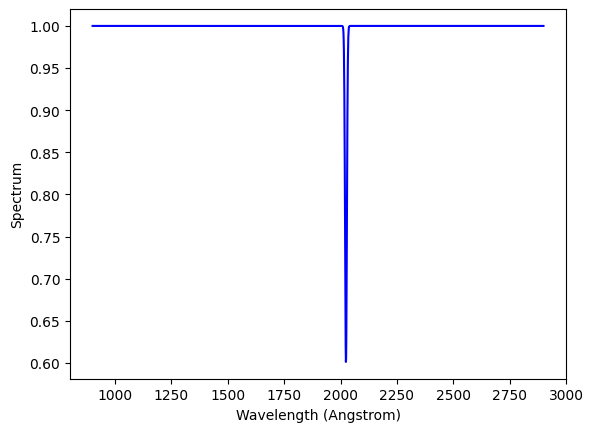

In [64]:
fig, ax = plt.subplots()
ax.plot(wavels, spect, 'blue')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Spectrum')

#### Now we want to make a Full Spectrum

We will do this by 
1. Generating a spectrum with a single line for each line in the list
2. Multiplying all of these spectrums together


In [65]:
# Generate a spectrum with a single line, if there are N lines in the list you get N spectra
def genspec(wavels, lwave, depth, lsigma):
    blank = blankspec(len(wavels))
    spect = []
    for k in range(len(wavels)):
        w = wavels[k]
        d = gauss(w, lwave, depth, lsigma)
        s = blank[k] + d
        spect.append(s)
    return spect

spectrums = []
for N in range(nlines):
    lwave = lwaves[N]
    depth = depths[N]
    spectrums.append(genspec(wavels, lwave, depth, lsigma))
    #plt.plot(wavels, spect, 'blue')
    #plt.show()


# Write to file for c++ testing
with open(r'spectrums.txt', 'w') as fp:
    for item in spectrums:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


Now we want to multipy the lines together to make a proper model of a spectrum, this is the part that can especially slow down our modeling of quesar winds. We're doing this first with a nested for-loop, to compare the differences in time for our methods, we will use time.perf_counter() to count how long it takes to run. Note that by default, a nested for loop will run in O(n^2) time, which is very slow.

We will also make a graph of our spectrum to check that we've made a reasonable-looking spectrum. 

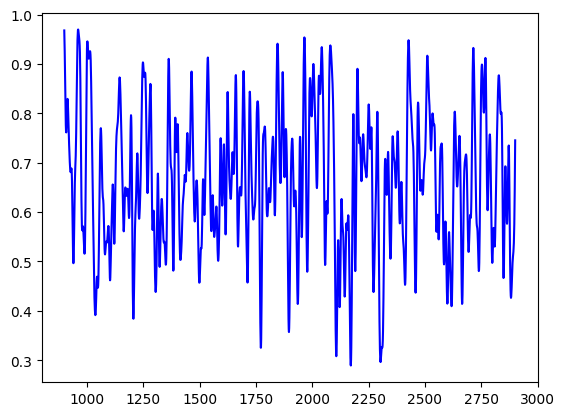

In [66]:
start_time_py = time.perf_counter()

# Multiply all the spectra together
final = spectrums[0]
for k in range(1, len(spectrums)):
    final = [final[n] * spectrums[k][n] for n in range(len(final))]
end_time_py = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [67]:
print('Basic Python Time:',end_time_py - start_time_py)

Basic Python Time: 0.16987220800001523


We have a nice graph and the time elapsed is alright, but it's important to note that this is for a very small number of lines in the model (only 1000) and to do actual research that number will be much higher, dramatically increasing the amount of time it will take to multiply all the lines together. 

## Now with Numpy: 

We'll use numpy as a middleman to mulitplying spectra entirely in C or C++ because [Numpy uses pre-compiled C code](https://numpy.org/doc/stable/user/whatisnumpy.html). By using the np.multiply() function we can multiply the spectra together in a single line of code. Which helps increase our runtime to O(n) time.

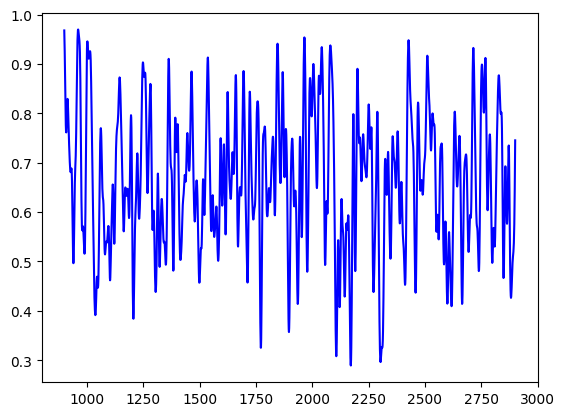

In [68]:
start_time_np = time.perf_counter()
# Multiply all the spectra together with numpy
final = spectrums[0]
for k in range(1, len(spectrums)):
    final = np.multiply(final, spectrums[k])
end_time_np = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [69]:
print("Python time: ", end_time_py - start_time_py)
print("Numpy  time: ", end_time_np - start_time_np)
print("Numpy is faster than python by a factor of:",(end_time_py - start_time_py)/(end_time_np - start_time_np) )

Python time:  0.16987220800001523
Numpy  time:  0.05238504099997954
Numpy is faster than python by a factor of: 3.242761764758027


Almost 3 times faster! 

So with just replacing the nested for-loop with a numpy function we've already dramatically reduced the time elapsed. 

Numpy is a very commonly used package, and often seen as one of the best, but we wanted to try at least one other package to compare, for this we chose __math__.

## Now with Math Prod

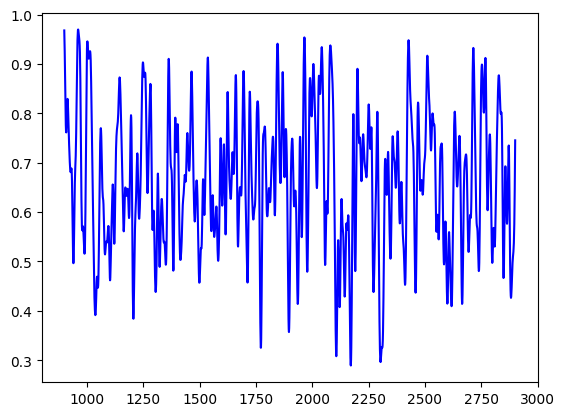

In [70]:

# Python3 program to multiply all values in the
# list using math.prod
 
import math
 
start_time_mp = time.perf_counter()
# Multiply all the spectra together with math
final3 = spectrums[0]
for k in range(1, len(spectrums)):
    final3 = math.prod( spectrums[k])
end_time_mp = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [71]:
print("Python time: ", end_time_py - start_time_py)
print("Numpy  time: ", end_time_np - start_time_np)
print("Math  time:", end_time_mp - start_time_mp)

Python time:  0.16987220800001523
Numpy  time:  0.05238504099997954
Math  time: 0.05572858300001826


Using math takes _longer_ than even basic python! This is a very interesting result as, like with numpy, [math is written in C](https://realpython.com/python-math-module/). Hopefully by trying this method we have saved some future headache by letting reserachers know not to try _math_. 

Now, we _could_ test other python packages, but it's important to note that, like stated before, most of them run on C or C++, so instead of further messing around with python, let's switch to C++

## Finally, we tried C++

Unfortunately we cannot continue this __Python__ notebook while writing code in C++, but we've ran each of the functions in both python and c++ against random lists of 1000 spectra in order to compare the time elapsed.

For one such test, these are the results:
| Method    | 1000 Time (seconds) | 10000 Time (seconds) | 
|-----------|----------------|----------------|
| pure python | 0.169872       | 1.467313       |
| math       | 0.055728       | 0.514634       |
| numpy      | 0.052385       | 0.473388       |
| c++        | 0.023182       | 0.236478       |
| c++ const  | 0.005601       | 0.054794       |
| c++ inplace| 0.005436       | 0.054567       |

As we can see, C++ is faster than any python method by a factor of about 2.4.
C++ was also much more consistent in our tests, with it taking about 0.0231 ±0.0020 seconds to run regardless, while the other methods could vary wildly depending on data.

#### C++ Methods

We tried three different methods in C++ to see if we could improve the time elapsed. The first was a one-to-one translation of the pure python method which involved two for loops. 

This function is shown below. With c++ being a compiled language, this method is inherently faster than the same implementation in python, by about 7.3 times. However, this implementation does not take advantage of any features that C++ has to be more efficient, and so we can do better.


```c++
vector<double> MultiplySpectrums(vector<vector<double> > spectrums)
{
    vector<double> result;
    result = spectrums[0];
    for (int i = 1; i < spectrums.size(); i++) {
        for (int j = 0; j < spectrums[i].size(); j++) {
            result[j] *= spectrums[i][j];
        }
    }
    return result;
}
```


### Const in C++

The first thing we tried was to use the const keyword in C++. This keyword tells the compiler that the value of the variable will not change. This allows the compiler to make optimizations that it otherwise would not be able to make. In this case, the compiler can store the value of the variable in a register, rather than having to access it from memory every time it is used. This is a very simple change, and it resulted in a 9.3 time improvement over the fastest method in numpy and around 4.1 times faster than the previous C++ method. 


```c++
vector<double> MultiplySpectrumsConst(const vector<vector<double> >& spectrums) {
    const size_t size = spectrums[0].size();
    vector<double> result = spectrums[0];

    for (size_t i = 1; i < spectrums.size(); ++i) {
        const vector<double>& spectrum = spectrums[i];
        for (size_t j = 0; j < size; ++j) {
            result[j] *= spectrum[j];
        }
    }

    return result;
}
```

### Inplace in C++
One other advantage to C++ is that it allows you to modify the input variables. This is called passing by reference. This allows you to avoid making copies of the input variables, which can be very expensive. This is especially true for large vectors. This method is called inplace multiplication, and it resulted in a 1.03 times improvement over the previous method. This is a very small improvement, but it is still an improvement.

```c++
void MultiplySpectrumsInPlace(vector<vector<double> >& spectrums, vector<double>& result) {
    const size_t size = spectrums[0].size();

    for (size_t i = 1; i < spectrums.size(); ++i) {
        const vector<double>& spectrum = spectrums[i];
        for (size_t j = 0; j < size; ++j) {
            result[j] *= spectrum[j];
        }
    }
}
```

### Conclusion

#### Why is c++ faster?
Overall, c++ is going to always be faster than python because it is a compiled language. This means that the code is converted into machine code before it is run. This allows the compiler to make optimizations that it otherwise would not be able to make. For example, the compiler can store the value of a variable in a register, rather than having to access it from memory every time it is used. Similarly with passing by reference, the compiler can avoid making copies of the input variables, which can be very expensive for large vectors. Because we have direct access to memory in c++, we gain a huge advantage over python which has to go through a middleman to access memory. 

#### Other optimizations
There are other optimizations that we could make to the c++ code. 
- For example, we could use SIMD instructions to multiply multiple values at once. This would allow us to multiply 4 values at once, which would result in a 4 times speedup. 
- We could also use multithreading to split the work up between multiple threads. This would allow us to take advantage of multiple cores, which would result in a 2 times speedup on a 2 core machine. 
- Using static arrays instead of vectors would also result in a speedup, because vectors have to dynamically allocate memory on the heap, while static arrays are allocated on the stack. Which is much faster to access and edit.
- We could also use a different data structure to store the spectrums. For example, we could use a 2d array instead of a vector of vectors. This would allow us to store the spectrums in a contiguous block of memory, which would result in fewer cache misses. This would result in a speedup because the processor would not have to wait for the data to be loaded into the cache.
- There may also be packages that we could use to speed up the code. For example, we could use the Eigen library to speed up the matrix multiplication.

Ultimately, there are many ways to optimize code, but the first and foremost method to shave off the most time in any language would be to get the runtime down from O(n^2) to O(n). Using packages in either python or c++ would be the easiest way to do this. Using a compiled langauge like c++ would be the next best option because it allows you to access memory to optimize the code.

### Notes:

To compile the c++ code, you will need a c++ compiler. The premade GenSpec executable was compiled on macos and can be run without compilation on macos. To compile the code yourself, you can run the following command in the terminal:

```bash
g++ -std=c++11 -O3 -o GenSpec GenSpec.cpp
```

To run the code, you can run the following command in the terminal:

```bash
./GenSpec spectrums.txt
```

The GenSpec.cpp file contains all of the c++ code. It includes all three functions described above, along with methods for reading in the data in the specified format. IF you have any questions please ask. Thank you!